# CL pair correlation functions.

In [1]:
import numpy as np
import pandas as pd
import h5py as hdf
import matplotlib.pyplot as plt
%matplotlib inline

# ms = [
#     {'c' : '#114B5F', 'fc' : '#208fb5'},
#     {'c' : '#47856E', 'fc' : '#59a689'},
#     {'c' : '#9ca903', 'fc' : '#cadb04'},
#     {'c' : '#eca300', 'fc' : '#ffba20'},
#     {'c' : '#bf3100', 'fc' : '#ff4404'}
# ]

colors = ["#2274a5", "#8ea604", "#f5bb00", "#d76a03", "#bf3100"]
data_dir = '/home/lukas/projects/thesis_data/1d_gsp/many_body/'

### Data definitions.

In [2]:
seeds = [1111, 2222, 3333, 4444, 5555]

np_to_param = {
    0.16 : {
        0.5 : [
            [25, (3,1)], 
            [75, (9,3)], 
            [125, (15,5)]
        ]
    },
    0.2 :{
        0.5 : [
            [20, (3,1)], 
            [60, (9,3)], 
            [100, (15,5)],
            [140, (21,7)]
        ]
    },
    0.25 : {
        0.5 : [
            [48, (9,3)], 
            [80, (15,5)], 
            [112, (21,7)]
        ]
    },
    0.4 :{
        0.0 : [
            [25, (5,5)],
            [35, (7,7)],
            [45, (9,9)],
            [55, (11,11)],
            [65, (13,13)],
            [75, (15,15)],
            [85, (17,17)],
            [95, (19,19)],
            [105, (21,21)],
            [115, (23,23)],
            [125, (25,25)],
            [135, (27,27)],
        ],
        0.25 : [
            [20, (5,3)],
            [100, (25,15)],
            [140, (35,21)],
        ],
        0.5 : [
            [30, (9,3)], 
            [50, (15,5)], 
            [70, (21,7)],
            [90, (27,9)],
            [110, (33,11)],
            [130, (39,13)]
        ],
        0.75 : [
            [20, (7,1)],
            [60, (21,3)],
            [100, (35,5)],
            [140, (49,7)],
        ]
    },
    0.5 : {
        0.5 : [
            [24, (9,3)], 
            [40, (15,5)], 
            [56, (21,7)],
            [72, (27,9)],
            [88, (33,11)],
            [104, (39,13)],
            [120, (45,15)],
            [136, (51,17)]
        ]
    },
}

def _betas(density):
    """ Get the available betas for a specific density.
    """
    return np.arange(13.0, 17.1, 2.0) if density < 0.4 else np.arange(4.0, 6.1, 1.0)

def param_to_p(param):
    return (param['npart'][0]-param['npart'][1])/float(np.sum(param['npart']))

def param_to_n(param):
    return sum(param['npart'])/float(param['nx'])

In [3]:
def _get_prefix(param):
    density = param_to_n(param)
    pol = param_to_p(param)
    if density == 0.4 and pol != 0.5:
        if param['nx'] < 60:
            return '7_constant_density/71_low_volume'
        elif param['nx'] >= 110 or (param['nx']==100 and pol==0.75):
            return '7_constant_density/73_high_volume'
        return '7_constant_density/72_med_volume'
    else:   
        if param['nx'] <= 60:
            if density < 0.4:
                return '6_constant_polarization/61_low_volume'
            return '6_constant_polarization/64_low_volume_low_beta'
        elif param['nx'] >=110:
            return '6_constant_polarization/63_high_volume'
        else:
            if density < 0.4:
                return '6_constant_polarization/62_med_volume'
            return '6_constant_polarization/65_med_volume_low_beta'
        

def get_data(param, var):
    """ Returns the array for a path in the hdf5 file.
    """
    data_file = data_dir + 'data_production/1D_all_correlators.hdf5'
    s = _get_prefix(param)
    grp = ('{:s}'.format(s) + 
           '/nx_{:d}'.format(param['nx']) +
           '/coupling_{:.1f}'.format(param['gamma']) +
           '/seed_{:d}'.format(param['seed']) +
           '/beta_{:.1f}'.format(param['beta']) +
           '/n_part_{:d}-{:d}'.format(*param['npart']) +
           '/mass_{:s}/'.format(param['mass'])
    )
    with hdf.File(data_file, 'r') as f:
#         print grp+var
        data = f[grp + var]
        return data[:]


def get_full_data(param, var):
    """ Retrieves a dataset across all seeds.
    """
    param['seed'] = seeds[0]
    res = np.array(get_data(param, var))
    for seed in seeds[1:]:
        param['seed'] = seed
        res += get_data(param, var)
    return res / len(seeds)

In [4]:
def average_and_fft(ospdm):
    """ Produces a pair distribution from the spatially distributed on-side pair density matrix.
    """
    vol = np.shape(ospdm)[0]
    
    # Average over spatial extent.qmstyle_paperqmstyle_paper
    r_dist = np.zeros(vol)
    for r in range(vol):
        r_dist += np.concatenate((ospdm[r,r:], ospdm[r,:r])) / vol
    
    # Wrap around for fft, perform fft and return result.
    res = np.fft.fftshift(np.fft.fft(r_dist)).real
    return res


def straighten(dm):
    """ From diagonal form to straight form.
    """
    l = np.shape(dm)[0]
    res = np.zeros_like(dm)
    for r in range(l):
        res[r, :] = np.concatenate((dm[r,r:], dm[r,:r]))
    return res

### Handy shortcuts.

In [5]:
def get_grid(param, norm=1.):
    """ Returns the symmetric box extent as axis for a plot, scaled with the specified norm.
    """
    grid = np.arange(-param['nx']//2, param['nx']//2) + int(param['nx'] % 2)
    if norm == 'k':
        norm = 2*np.pi/param['nx']
    return norm * grid


def wavenumbers(param, bare=False):
    """ Returns the important wavevectors:
            
            kF_up - kF_down, kF_up + kF_down
    """
    kF_up, kF_down = np.array(param['npart']) / float(param['nx'])*np.pi
    
    q = int(float(np.round((kF_up-kF_down)*param['nx'])/(2.*np.pi)))
    l = int(float(np.round((kF_up+kF_down)*param['nx'])/(2.*np.pi)))
#     print q, l
    
    if bare:
        return q, l
    return q*2*np.pi/float(param['nx']), l*2*np.pi/float(param['nx'])

## Detect FFLO pattern.

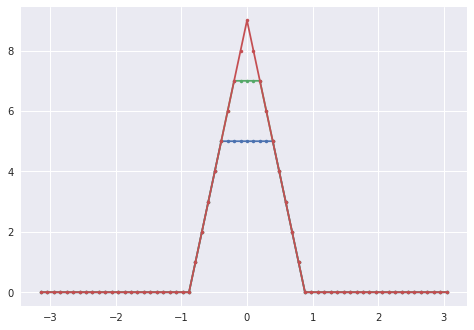

In [6]:
def npair_0(nup, ndown, L):
    """ Non-interacting pair-distribution matrix.
        (works only for odd particle numbers).
    """
    bar = lambda n: (n-1)//2 if (n % 2) else (n-2)//2
    nbu, nbd = bar(nup), bar(ndown)
    
    # Heaviside theta function.
    theta = lambda x: (x>=0).astype(int)
    
    # k axis.
    k = np.arange(-L//2, L//2, 1)
    
    # pair momentum distribution.
    npair = (
        (2*nbd + 1)*theta(abs(nbu-nbd) - abs(k) - 1) +
        (nbu+nbd+1-abs(k))*theta(abs(k)-abs(nbu-nbd))*theta(abs(nbu+nbd)-abs(k))
    )
    return k*2*np.pi/L, npair
    

with plt.style.context('seaborn'):
    fig, ax = plt.subplots()
    
    x, y = npair_0(13, 5, 64)
    ax.plot(x, y, marker='.', ls='-')
    
    x, y = npair_0(11, 7, 64)
    ax.plot(x, y, marker='.', ls='-')
    
    x, y = npair_0(9, 9, 64)
    ax.plot(x, y, marker='.', ls='-')

# Figure 2 of the Scipost paper.

0.4 0.0 (135)
0.4 0.25 (140)
0.4 0.5 (130)
0.4 0.75 (140)


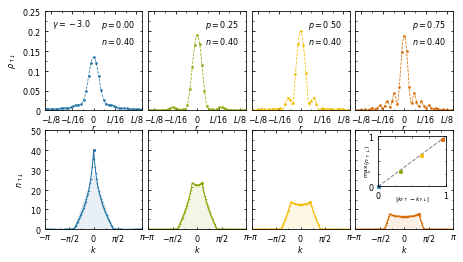

In [8]:
from scipy.interpolate import interp1d
plt.rcParams['axes.facecolor'] = 'white'

sets = [
    {'nx' : 135, 'npart' : [27,27]},
    {'nx' : 140, 'npart' : [35,21]},
    {'nx' : 130, 'npart' : [39,13]},
    {'nx' : 140, 'npart' : [49,7]},
]

param = {
    'mass' : '1.0-1.0',
    'seed' : 2222,
    'gamma' : 3.0,
}

with plt.style.context('phd_thesis'):
    fig, axes = plt.subplots(2, len(sets))
    fig.set_size_inches(6.3, 3.5)
    ax = axes.flatten()
    insax = fig.add_axes([0.825, 0.29, 0.15, 0.2])
    
    for beta in [5.0]:
        param['beta'] = beta
        for k, s in enumerate(sets):
            param.update(s)
            p, n = param_to_p(param), param_to_n(param)
            data = get_data(param, 'ospdm')[:].real

            ku = k+len(sets)
            
            # n2k.
            k_axis = get_grid(param, 'k')
            n_pair = average_and_fft(data)
            n_pair_normed = n_pair*np.prod(param['npart']) / np.sum(n_pair)
            line, = ax[ku].plot(k_axis, n_pair_normed,
                                            linestyle='-', marker='.', color=colors[k], markersize=1.5)
            knfree, nfree = npair_0(*param['npart'], param['nx'])
#             ax[ku].plot(knfree, nfree, linestyle='--', marker='', color='gray', lw=0.5)
            ax[ku].plot(knfree, nfree, linestyle='--', marker='', color=colors[k], lw=0.5, alpha=0.5)
            ax[ku].fill_between(knfree, nfree, [0]*len(nfree), color=colors[k], alpha=0.1, lw=0)

            ax[ku].set_xlabel('$k$', labelpad=0)
            ax[ku].set_xlim(-np.pi, np.pi)
            ax[ku].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
            ax[ku].set_xticks([-3*np.pi/4, -np.pi/4, np.pi/4, 3*np.pi/4], minor=True)
            ax[ku].set_xticklabels(['$-\\pi$', '$-\\pi/2$', '$0$', '$\\pi/2$', '$\\pi$'])
            
            ax[ku].set_yticks([0, 10, 20, 30, 40, 50])
            ax[ku].set_yticks([5, 15, 25, 35, 45], minor=True)
            ax[ku].set_ylim(0, 50)
            if not k:
                ax[len(sets)].set_ylabel('$n_{\\uparrow\\!\\!\\!\\downarrow}$')
                ax[len(sets)].set_yticklabels(['$0$', '$10$', '$20$', '$30$', '$40$', '$50$'])
            else:
                ax[ku].set_yticklabels([])

            # -------------------------------
            
            c = int(param['nx'])//2
            q, l = wavenumbers(param)
            ind = np.argmax(n_pair_normed[:int(param['nx']/2)+10])
            pp = np.abs(k_axis[ind])
            print(n, p, '({:d})'.format(param['nx']))
            insax.plot(p*n*np.pi, pp, color=line.get_color(), clip_on=False, markersize=3)
            ax[ku].plot(-k_axis[ind], n_pair_normed[ind], color=line.get_color(), clip_on=False, markersize=2)

            # -------------------------------

            # rho2.
            r_axis = get_grid(param)
            rho2 = np.fft.fftshift(np.mean(straighten(data), axis=0))
            rho2 = np.abs(rho2/ np.sum(np.abs(rho2)))
            ax[k].plot(r_axis, rho2, linestyle='', marker='s', color=colors[k], label='$p = {:.2f}$'.format(p), markersize=1.5)

            # rho2 (interpolated).
            r_fine = np.linspace(np.min(r_axis), np.max(r_axis), len(r_axis)*5)
            rho2_int = interp1d(r_axis, rho2, kind='cubic')
            ax[k].plot(r_fine, rho2_int(r_fine), color=line.get_color(), linestyle='--', marker='', label='$n = {:.2f}$'.format(n), lw=0.75)

            
            ax[k].set_xlabel('$r$', labelpad=-2)
            if not k:
                ax[k].set_ylabel('$\\rho_{\\uparrow\\!\\!\\!\\downarrow}$')
                ax[k].set_yticklabels(['$0$', '$0.05$', '$0.1$', '$0.15$', '$0.2$', '$0.25$'])
            else:
                ax[k].set_yticklabels([])

            ax[k].set_xlim(-param['nx']/7, param['nx']/7)
            ax[k].set_xticks([-param['nx']/8, -param['nx']/16, 0, param['nx']/16, param['nx']/8])
            ax[k].set_xticks([-3*param['nx']/32, -param['nx']/32, param['nx']/32, 3*param['nx']/32], minor=True)
            ax[k].set_xticklabels(['$-L/8$', '$-L/16$', '$0$', '$L/16$', '$L/8$'])
            
            ax[k].set_ylim(0, 0.25)
            ax[k].set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
            ax[k].set_yticks([0.025, 0.125, 0.175, 0.225], minor=True)
            ax[k].legend(loc='upper right', markerscale=0, handlelength=0, bbox_to_anchor=(0., 1.0, 1.0, 0))


            
    # ------------------------------------------------------

    lin = np.linspace(0, 1., 100)
    insax.plot(lin, lin, linestyle='--', color='gray', marker='', zorder=0)
    
    insax.set_xlim(0, 1)
    insax.set_xlabel('$|k_{\\mathrm{F}\\uparrow} - k_{\\mathrm{F}\\downarrow}|$', labelpad=-6, fontsize=6)
    insax.set_xticks([0, 1])
    insax.set_xticks([0.25, 0.5, 0.75], minor=True)
    insax.set_xticklabels(['$0$', '$1$'])
    
    insax.set_ylim(0, 1)
    insax.set_ylabel('$\max_k(n_{\\uparrow\\downarrow})$', labelpad=-6, fontsize=6)
    insax.set_yticks([0, 1])
    insax.set_yticks([0.25, 0.5, 0.75], minor=True)
    insax.set_yticklabels(['$0$', '$1$'])
    
    # ------------------------------------------------------
    
    fig.text(0.105, 0.925, '$\\gamma = {:.1f}$'.format(-param['gamma']))
    fig.subplots_adjust(left=0.09, bottom=0.12, right=0.99, top=0.985, wspace=0.06)
#     fig.savefig(plot_dir + '1DGSP_op_pdm.pdf')
    fig.savefig('1d_gsp_pair_correlation.pdf')

In [8]:
def op_fflo(x, Q, A, delta):
    return A*np.abs(np.cos(Q*x)) / (x**delta)

[0.36373851 1.82769446]
0.0
[1.57037121 2.61818081]
0.3141592653589793
[0.47580127 1.86381929]
0.6283185307179586
[0.10277112 1.05635801]
0.942477796076938
[0.29728531 1.66178396]
0.0
[1.24891501 2.45513877]
0.3141592653589793
[0.42441462 1.78946069]
0.6283185307179586
[0.1121073  1.08132421]
0.942477796076938
[0.25909019 1.56022765]
0.0
[1.33897774 2.52133375]
0.3141592653589793
[0.39639913 1.73391777]
0.6283185307179586
[0.11254336 1.07527429]
0.942477796076938


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in power
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


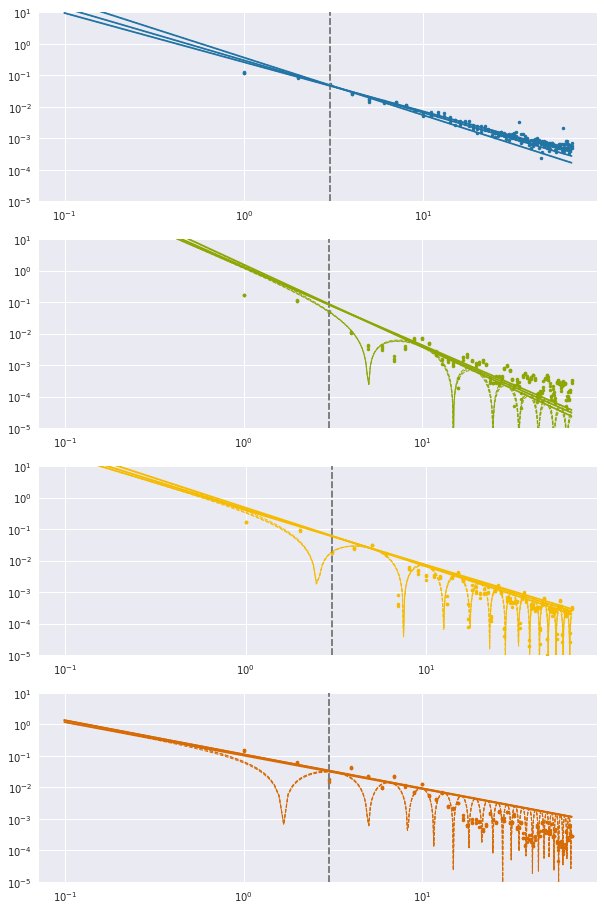

In [51]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

sets = [
    {'nx' : 135, 'npart' : [27,27]},
    {'nx' : 140, 'npart' : [35,21]},
    {'nx' : 130, 'npart' : [39,13]},
    {'nx' : 140, 'npart' : [49,7]},
]

param = {
    'mass' : '1.0-1.0',
    'seed' : 2222,
    'gamma' : 3.0,
}

with plt.style.context('seaborn'):
    fig, axes = plt.subplots(len(sets),1)
    fig.set_size_inches(10, 16)
    ax = axes.flatten()
    
    
    for beta in [4.0, 5.0, 6.0]:
        param['beta'] = beta
        for k, s in enumerate(sets):
            param.update(s)
            p, n = param_to_p(param), param_to_n(param)
            data = get_data(param, 'ospdm')[:].real

            # -------------------------------

            # rho2.
            r_axis = get_grid(param)
            rho2 = np.fft.fftshift(np.mean(straighten(data), axis=0))
            rho2 = np.abs(rho2/ np.sum(np.abs(rho2)))
            line = ax[k].plot(r_axis, rho2, linestyle='', marker='.', color=colors[k], label='$p = {:.2f}$'.format(p))

            # rho2 (fit).
            r_fine = np.linspace(0, np.max(r_axis), len(r_axis)*5)
            
            cutoff = param['nx']//2 + 3
            xp, yp = r_axis[cutoff:], rho2[cutoff:]
            ax[k].axvline(np.min(xp), ls='--', color='gray')
            
            
            q = p*n*np.pi
            f = lambda x, a, delta: op_fflo(x, q, a, delta)
            p, c = curve_fit(f, xp, yp, p0=(1, 1.1))
            print(p)
            print(q)
            ax[k].plot(r_fine, r_fine**(-p[-1])*p[0], ls='-', color=line[0].get_color(),)
            ax[k].plot(r_fine, op_fflo(r_fine, q, *p), color=line[0].get_color(), linestyle='--', marker='', label='$n = {:.2f}$'.format(n), lw=1.)

            
#             p, c = curve_fit(op_fflo, xp, yp, p0=(p*n*np.pi, 1, 1.1))
#             print(p)
#             ax[k].plot(r_fine, r_fine**(-p[-1])*p[1], ls='-', color=line[0].get_color(),)
#             ax[k].plot(r_fine, op_fflo(r_fine, *p), color=line[0].get_color(), linestyle='--', marker='', label='$n = {:.2f}$'.format(n))

            
            ax[k].set_xscale('log')
            ax[k].set_yscale('log')
            ax[k].set_ylim(1e-5, 10)

    
    # ------------------------------------------------------
    
#     fig.savefig('1d_gsp_pair_correlation.pdf')

In [72]:
from copy import copy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

sets = [
    {'nx' : 135, 'npart' : [27,27]},
    {'nx' : 140, 'npart' : [35,21]},
    {'nx' : 130, 'npart' : [39,13]},
    {'nx' : 140, 'npart' : [49,7]},
]

param = {
    'mass' : '1.0-1.0',
    'gamma' : 3.0,
    'seed' : 2222,
}

df = pd.DataFrame()

for seed in [1111, 2222, 3333, 4444, 5555]:
    param['seed'] = seed
    for beta in [4.0, 5.0, 6.0]:
        param['beta'] = beta
        for k, s in enumerate(sets):
            param.update(s)
            p, n = param_to_p(param), param_to_n(param)
            data = get_data(param, 'ospdm')[:].real

            rho2 = np.fft.fftshift(np.mean(straighten(data), axis=0))
            rho2 = np.abs(rho2/ np.sum(np.abs(rho2)))

            r_axis = get_grid(param)

            res = copy(param)

            # -------------------------------

            cutoff = param['nx']//2 + 3
            xp, yp = r_axis[cutoff:], rho2[cutoff:]

            q = p*n*np.pi
            f = lambda x, a, delta: op_fflo(x, q, a, delta)
            popt, c = curve_fit(f, xp, yp, p0=(1, 1))

            res['q'] = q
            res['delta'] = popt[-1]
            res['p'] = p

            df = df.append(pd.Series(res), ignore_index=True)

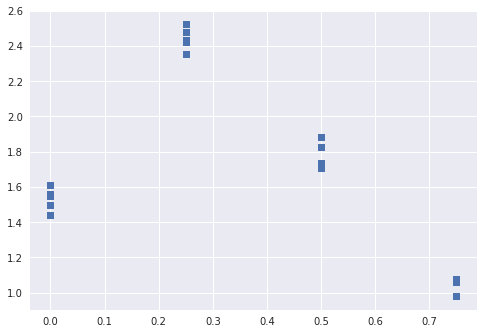

In [78]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots()
    
    for b, beta in enumerate([6.0]):
        sub = df[df['beta'] == beta]
        ax.plot(sub['p'], sub['delta'], marker='s', ls='')